<a href="https://colab.research.google.com/github/Ksenia-90/NN/blob/lesson_5/dz_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Рекуррентные нейронные сети

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
%matplotlib inline
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [60]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/airline-passengers.csv', parse_dates=['Month'], index_col=0)


In [61]:
data.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [62]:
data['year'] = data.index.year
data['month'] = data.index.month

In [63]:
def norm(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [64]:
train_split = 80
data_norm = norm(data.values, train_split)
data = pd.DataFrame(data_norm)

In [65]:
lIndexes = [0,1,2]
bias = 10
train_data = data.iloc[0 : train_split - 1,lIndexes]
test_data = data.iloc[train_split+bias:,lIndexes]

In [66]:
train_data.head()

,0,1,2
0,-1.434472,-1.476169,-1.555463
1,-1.328802,-1.476169,-1.261980
2,-1.082238,-1.476169,-0.968496
3,-1.135073,-1.476169,-0.675012
4,-1.275967,-1.476169,-0.381529


In [67]:
step = 1
maxlen = 3
h = 1
learning_rate = 0.001
batch_size = 25

In [68]:
x_train = train_data[[train_data.columns[i] for i in range(3)]].values
y_train = data.iloc[maxlen:(maxlen + train_split-1),0].values
x_test = test_data.iloc[:(len(test_data)) - maxlen+1][[test_data.columns[i] for i in range(3)]].values
y_test = data.iloc[(len(train_data)+bias+maxlen):,0].values

In [69]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=maxlen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=maxlen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [70]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (25, 3, 3)
Target shape: (25,)


In [74]:
epochs=300

callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(128, return_sequences="True"))
model.add(Conv1D(256, 3, activation='relu', padding='same'))
model.add(Conv1D(256, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="sgd", metrics=['mse'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_test)

Epoch 1/300
4/4 [==============================] - 4s 308ms/step - loss: 1.0008 - mse: 1.0008 - val_loss: 14.0418 - val_mse: 14.0418
Epoch 2/300
4/4 [==============================] - 0s 41ms/step - loss: 0.9928 - mse: 0.9928 - val_loss: 12.7730 - val_mse: 12.7730
Epoch 3/300
4/4 [==============================] - 0s 44ms/step - loss: 1.0425 - mse: 1.0425 - val_loss: 11.8050 - val_mse: 11.8050
Epoch 4/300
4/4 [==============================] - 0s 45ms/step - loss: 1.1051 - mse: 1.1051 - val_loss: 11.0373 - val_mse: 11.0373
Epoch 5/300
4/4 [==============================] - 0s 42ms/step - loss: 1.1658 - mse: 1.1658 - val_loss: 10.4203 - val_mse: 10.4203
Epoch 6/300
4/4 [==============================] - 0s 43ms/step - loss: 1.2114 - mse: 1.2114 - val_loss: 9.8966 - val_mse: 9.8966
Epoch 7/300
4/4 [==============================] - 0s 45ms/step - loss: 1.2407 - mse: 1.2407 - val_loss: 9.4345 - val_mse: 9.4345
Epoch 8/300
4/4 [==============================] - 0s 44ms/step - loss: 1.2530 

In [75]:
predict= model.predict(dataset_train).flatten()
predict_test = model.predict(dataset_test).flatten()

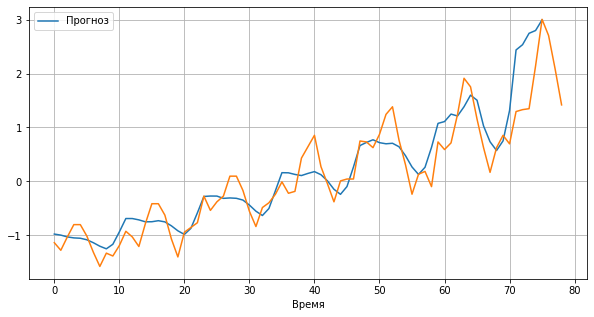

In [76]:
start = 0
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predict[h+start:h+train_split], 
         label='Прогноз')
plt.plot(y_train.flatten()[start:train_split])
plt.xlabel('Время')
plt.legend()
plt.show()

##Генерация текста на основе книжки «Алиса в стране чудес»

In [ ]:
import numpy as np
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential

In [ ]:
# построчное чтение из примера с текстом 
with open("alice_in_wonderland.txt", 'rb') as _in:
    lines = []
    for line in _in:
        line = line.strip().lower().decode("ascii", "ignore")
        if len(line) == 0:
            continue
        lines.append(line)
text = " ".join(lines)
chars = set(text)
nb_chars = len(chars)

In [ ]:
len(chars)

55

In [ ]:
# создание индекса символов и reverse mapping чтобы передвигаться между значениями numerical
# ID and a specific character. The numerical ID will correspond to a column
# ID и определенный символ. Numerical ID будет соответсвовать колонке
# число при использовании one-hot кодировки для представление входов символов
char2index = {c: i for i, c in enumerate(chars)}
index2char = {i: c for i, c in enumerate(chars)}

In [ ]:
index2char

{0: 'c',
 1: 'w',
 2: '?',
 3: ' ',
 4: 'h',
 5: ')',
 6: 'e',
 7: 'n',
 8: 'z',
 9: '.',
 10: 't',
 11: '%',
 12: 'u',
 13: '5',
 14: ';',
 15: '9',
 16: 'o',
 17: '[',
 18: '/',
 19: '#',
 20: 'p',
 21: '6',
 22: '@',
 23: 'm',
 24: '2',
 25: '1',
 26: '$',
 27: 'a',
 28: '!',
 29: 'i',
 30: 'l',
 31: ',',
 32: '_',
 33: '8',
 34: '7',
 35: '*',
 36: 'b',
 37: 'j',
 38: 'v',
 39: 'k',
 40: 'y',
 41: '4',
 42: 's',
 43: ':',
 44: 'q',
 45: '(',
 46: 'r',
 47: 'g',
 48: 'x',
 49: '0',
 50: 'd',
 51: 'f',
 52: '-',
 53: ']',
 54: '3'}

In [ ]:
# для удобства выберете фиксированную длину последовательность 10 символов 
SEQLEN, STEP = 10, 1
input_chars, label_chars = [], []

# конвертация data в серии разных SEQLEN-length субпоследовательностей
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i: i + SEQLEN])
    label_chars.append(text[i + SEQLEN])

In [ ]:
len(input_chars)

158773

In [ ]:
input_chars[0], label_chars[0]

('project gu', 't')

In [ ]:
input_chars[1], label_chars[1]

('roject gut', 'e')

In [ ]:
# Вычисление one-hot encoding входных последовательностей X и следующего символа (the label) y

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1

C:\Users\Pirozhok\AppData\Local\Temp\ipykernel_23436\1321165275.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
C:\Users\Pirozhok\AppData\Local\Temp\ipykernel_23436\1321165275.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(input_chars), nb_chars), dtype=np.

In [ ]:
X.shape

(158773, 10, 55)

In [ ]:
# установка ряда метапамертров  для нейронной сети и процесса тренировки
BATCH_SIZE, HIDDEN_SIZE = 128, 128
NUM_ITERATIONS = 10 # 25 должно быть достаточно
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

In [ ]:
'''
Создание очень простой рекуррентной нейронной сети. В ней будет один реккурентный закодированный входной слой. 
За ним последует полносвязный слой связанный с набором возможных следующих символов, 
которые конвертированы в вероятностные результаты через стандартную softmax активацию 
с multi-class cross-encoding loss функцию ссылающуются на предсказание one-hot encoding лейбл символа
'''

model = Sequential()
model.add(
    GRU(  # вы можете изменить эту часть на LSTM или SimpleRNN, чтобы попробовать альтернативы
        HIDDEN_SIZE,
        return_sequences=True,
        input_shape=(SEQLEN, nb_chars),
        unroll=True
    )
)

model.add(
    GRU(  # вы можете изменить эту часть на LSTM или SimpleRNN, чтобы попробовать альтернативы
        HIDDEN_SIZE,
        return_sequences=False,
        unroll=True
    )
)

model.add(Dense(nb_chars))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

In [ ]:
# выполнение серий тренировочных и демонстрационных итераций 
for iteration in range(NUM_ITERATIONS):

    # для каждой итерации запуск передачи данных в модель 
    print("=" * 50)
    print("Итерация #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Select a random example input sequence.
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    # для числа шагов предсказаний использование текущей тренируемой модели 
    # конструирование one-hot encoding для тестирования input и добавление предсказания.
    print("Генерация из посева: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):

        # здесь one-hot encoding.
        X_test = np.zeros((1, SEQLEN, nb_chars))
        for j, ch in enumerate(test_chars):
            X_test[0, j, char2index[ch]] = 1

        # осуществление предсказания с помощью текущей модели.
        pred = model.predict(X_test, verbose=0)[0]
        y_pred = index2char[np.argmax(pred)]

        # вывод предсказания добавленного к тестовому примеру 
        print(y_pred, end="")

        # инкрементация тестового примера содержащего предсказание
        test_chars = test_chars[1:] + y_pred

Итерация #: 0
1241/1241 [==============================] - 67s 49ms/step - loss: 2.1828
Генерация из посева: t before t
t before the project and the project and the project and the project and the project and the project and the p==================================================
Итерация #: 1
1241/1241 [==============================] - 60s 49ms/step - loss: 1.7513
Генерация из посева:  baby--the
 baby--the had not and the rabbit and the rabbit and the rabbit and the rabbit and the rabbit and the rabbit a==================================================
Итерация #: 2
1241/1241 [==============================] - 62s 50ms/step - loss: 1.5765
Генерация из посева: alice appe
alice appeared to the gryphon and the gryphon and the gryphon and the gryphon and the gryphon and the gryphon ==================================================
Итерация #: 3
1241/1241 [==============================] - 60s 48ms/step - loss: 1.4625
Генерация из посева: ut i dont 
ut i dont the more the more the more 